# Refreshing the Cortés-Ciriano Datasets

A lot of cheminformaticians use the datasets from [*Deep Confidence: A Computationally Efficient Framework for Calculating Reliable Prediction Errors for Deep Neural Networks*](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00542) by Cortés-Ciriano (https://twitter.com/isidrolauscher) and Bender (https://twitter.com/AndreasBenderUK). Here's Table 1 from the manuscript, describing 24 datasets corresponding to 24 protein targets:

![](cortes-ciriano-table-1.png)

Unfortunately, these were published in 2018 using ChEMBL 23 (2017-05-18) and the paper does not include code to regenerate these 24 datasets. Here's what the manuscript says about how it was made:

> We gathered IC50 data for 24 diverse protein targets and receptors from the ChEMBL database version 23 using the [chembl_webresource_client](https://github.com/chembl/chembl_webresource_client) python module. Only IC<sub>50</sub> values for small molecules that satisfied the following filtering criteria were retained: (i) an activity unit equal to `nM`, (ii) activity relationship equal to `=`, (iii) target type equal to `SINGLE PROTEIN`, and (iv) organism equal to Homo sapiens. IC<sub>50</sub> values were modeled in a logarithmic scale (pIC<sub>50</sub> = −log<sub>10</sub> IC<sub>50</sub>). The average pIC<sub>50</sub> value was calculated when multiple pIC<sub>50</sub> values were available for the same compound.

Note that pChEMBL values are the same as pIC<sub>50</sub> when the measurement is for inhibitory concentrations. Additionally, there are some methodological issues going on here, since the arithmetic mean isn't appropriate for log values. Instead, the geometric mean should be used:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">pIC50&#39;s should be aggregated using geometric mean<br><br>But it&#39;s generally not reasonable to aggregate across across an arbitrary set of assays</p>&mdash; Rajarshi Guha (@rguha@nerdculture.de) (@rguha) <a href="https://twitter.com/rguha/status/1586677163775893504?ref_src=twsrc%5Etfw">October 30, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Further, these aging datasets are missing the benefit of many new assays added to ChEMBL. Therefore, this notebook has two goals:

1. See if we can automate rebuilding these datasets using a modern version of ChEMBL (facilitated by [`chembl-downloader`](https://github.com/cthoyt/chembl-downloader))
2. Assess how much variability has been introduced since the 2018 publication for each target based on new data

In [1]:
import sys
import time
import zipfile

import matplotlib.pyplot as plt
import matplotlib_inline
import pandas as pd
import pystow
import seaborn as sns
from matplotlib_venn import venn2, venn3
from rdkit import Chem
from tqdm.auto import tqdm

import chembl_downloader
from chembl_downloader.contrib import get_target_smi_df

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [3]:
print(sys.version)

3.10.8 (main, Oct 13 2022, 10:17:43) [Clang 14.0.0 (clang-1400.0.29.102)]


In [4]:
print(time.asctime())

Sat Nov 19 22:11:26 2022


In [5]:
mappings = [
    ("A2a", "CHEMBL1867", 203),
    ("ABL1", "CHEMBL1862", 773),
    ("Acetylcholinesterase", "CHEMBL220", 3159),
    ("Aurora-A", "CHEMBL4722", 2125),
    ("B-raf", "CHEMBL5145", 1730),
    ("Cannabinoid", "CHEMBL218", 1116),
    ("Carbonic", "CHEMBL205", 603),
    ("Caspase", "CHEMBL2334", 1606),
    ("Coagulation", "CHEMBL204", 1700),
    ("COX-1", "CHEMBL221", 1343),
    ("COX-2", "CHEMBL230", 2855),
    ("Dihydrofolate", "CHEMBL202", 584),
    ("Dopamine", "CHEMBL217", 479),
    ("Ephrin", "CHEMBL222", 1740),
    ("erbB1", "CHEMBL203", 4868),
    ("Estrogen", "CHEMBL206", 1705),
    ("Glucocorticoid", "CHEMBL2034", 1447),
    ("Glycogen", "CHEMBL262", 1757),
    ("HERG", "CHEMBL240", 5207),
    ("JAK2", "CHEMBL2971", 2655),
    ("LCK", "CHEMBL258", 1352),
    ("Monoamine", "CHEMBL1951", 1379),
    ("opioid", "CHEMBL233", 840),
    ("Vanilloid", "CHEMBL4794", 1923),
]

## Load Old Data

While the ACS publication links to the supplementary material at https://pubs.acs.org/doi/suppl/10.1021/acs.jcim.8b00542/suppl_file/ci8b00542_si_001.zip, it's obfuscated in a way such that automatic download isn't possible. I found the corresponding dataset on FigShare and will use that link with `pystow` to get it.

In [6]:
url = "https://figshare.com/ndownloader/files/13426988"
path = pystow.ensure("cheminf", url=url)

Inside the zip file are SDF files corresponding to the 24 targets. Each have the structures, ChEMBL identifiers, and pIC<sub>50</sub>'s for hundreds or thousands of molecules.

In [7]:
reference_dfs = {}
with zipfile.ZipFile(path) as zip_file:
    for stem, target_chembl_id, _ in tqdm(mappings, unit="file"):
        with zip_file.open(f"Datasets/{stem}.sdf") as file:
            rows = [
                (
                    Chem.MolToSmiles(molecule),
                    molecule.GetProp("ChEMBL_ID"),
                    float(molecule.GetProp("pIC50")),
                )
                for molecule in Chem.ForwardSDMolSupplier(file)
            ]
        reference_dfs[target_chembl_id] = pd.DataFrame(
            rows,
            columns=[
                "canonical_smiles",
                "molecule_chembl_id",
                "pchembl_value",
            ],
        )

  0%|          | 0/24 [00:00<?, ?file/s]

## Refresh Data

The following function best implements what was described in the manuscript. A future version of the dataset could switch out `aggregate="mean"` for `aggregate="gmean"` to be more theoretically correct, though, both aggregations disregard the potential inter-assay variability which could also be important.

Note the importance of filters for standard type, standard relation, target type, and taxa.

In [8]:
def _get_target_dfs(version: str, *, aggregate):
    return {
        target_chembl_id: get_target_smi_df(
            target_chembl_id,
            version=version,
            aggregate=aggregate,
            target_type="SINGLE PROTEIN",
            standard_relation="=",
            standard_type="IC50",
            tax_id="9606",
        )
        for _, target_chembl_id, _ in tqdm(mappings)
    }

Get the data from the reported version, ChEMBL 23, from the paper to see if we can reproduce their datasets.

In [9]:
refresh_dfs = _get_target_dfs("23", aggregate="mean")

  0%|          | 0/24 [00:00<?, ?it/s]

Get the latest data to see what the changes are.

In [10]:
version = chembl_downloader.latest()
latest_dfs = _get_target_dfs(version, aggregate="mean")

  0%|          | 0/24 [00:00<?, ?it/s]

### Tabular Summary

From the following counts of which molecules are available for each protein, it shows that there are discrepancies between the reference datasets and what's in ChEMBL 23. This means that there were probably manual interventions that were not explicitly documented, decreasing the trust in the original dataset. There are major discrepancies between the reference/refreshed datasets and the latest version in ChEMBL for many targets.

In [11]:
summary_rows = []
for name, target_chembl_id, _ in mappings:
    reference_df = reference_dfs[target_chembl_id]
    refresh_df = refresh_dfs[target_chembl_id]
    latest_df = latest_dfs[target_chembl_id]
    summary_rows.append(
        (
            name,
            target_chembl_id,
            len(reference_df.index),
            len(refresh_df.index),
            len(latest_df.index),
        )
    )

summary_df = pd.DataFrame(
    summary_rows,
    columns=[
        "name",
        "target_chembl_id",
        "reference_count",
        "refresh_count",
        "latest_count",
    ],
)
summary_df

,name,target_chembl_id,reference_count,refresh_count,latest_count
0,A2a,CHEMBL1867,203,206,210
1,ABL1,CHEMBL1862,773,773,1463
2,Acetylcholinesterase,CHEMBL220,3159,3191,4788
3,Aurora-A,CHEMBL4722,2125,2125,2529
4,B-raf,CHEMBL5145,1730,1730,3886
5,Cannabinoid,CHEMBL218,1116,1116,1364
6,Carbonic,CHEMBL205,603,606,754
7,Caspase,CHEMBL2334,1606,1609,1671
8,Coagulation,CHEMBL204,1700,1705,1888
9,COX-1,CHEMBL221,1343,1344,1544


### Graphical Summary

Venn diagrams show that there are a minimal number of molecules that were available in the reference datasets but are either not queriable from ChEMBL 23 or the latest ChEMBL.

/Users/cthoyt/.virtualenvs/cheminf310/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


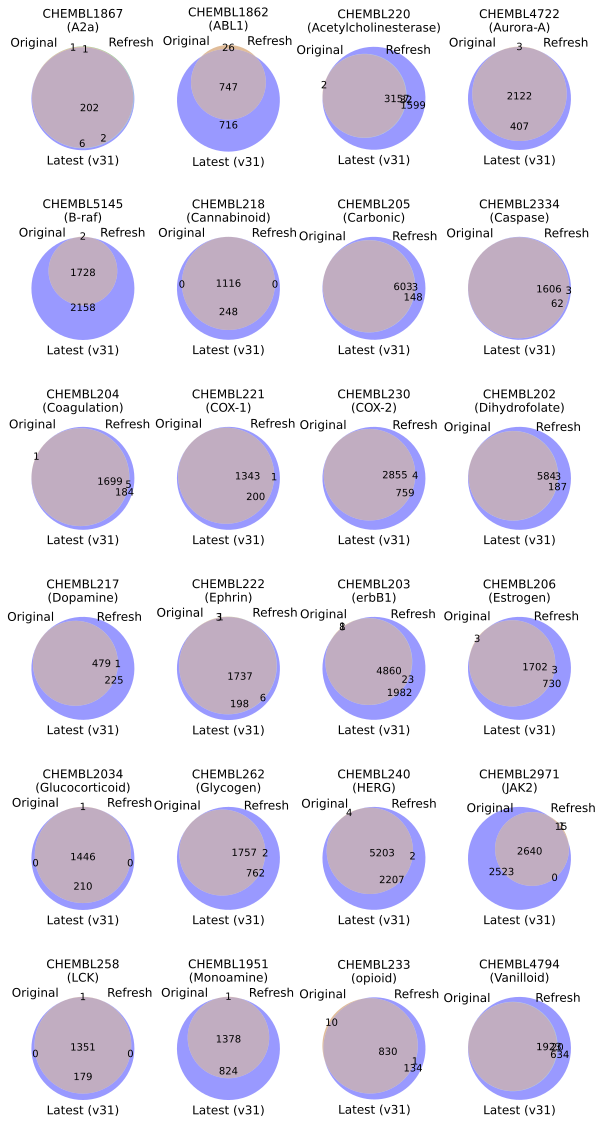

In [12]:
fig, axes = plt.subplots(6, 4, figsize=(10.0, 20.0))

for (name, target_id, _), ax in zip(mappings, axes.ravel()):
    venn3(
        subsets=[
            set(reference_dfs[target_id].molecule_chembl_id),
            set(refresh_dfs[target_id].molecule_chembl_id),
            set(latest_dfs[target_id].molecule_chembl_id),
        ],
        set_labels=[
            "Original",
            "Refresh",
            f"Latest (v{version})",
        ],
        ax=ax,
    )
    ax.set_title(f"{target_id}\n({name})")

plt.show()

## Value Comparison

The following histgrams show the differences between the reference datasets' pChEMBL values and the latest version of ChEMBL (post-aggregation).

  0%|          | 0/24 [00:00<?, ?it/s]

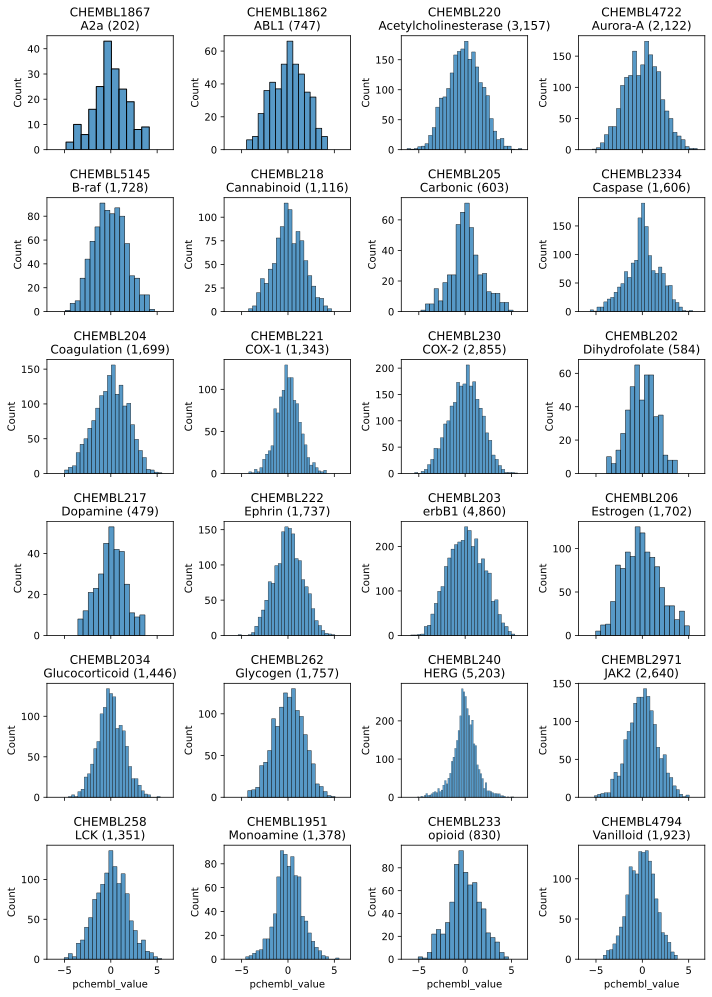

In [13]:
fig, axes = plt.subplots(6, 4, figsize=(10.0, 14.0), sharex=True)

for (name, target_chembl_id, _), ax in zip(tqdm(mappings), axes.ravel()):
    latest_df = latest_dfs[target_chembl_id]
    reference_df = reference_dfs[target_chembl_id]

    overlapping_molecule_chembl_ids = sorted(
        set(latest_df.molecule_chembl_id).intersection(reference_df.molecule_chembl_id)
    )

    idx = latest_df.molecule_chembl_id.isin(overlapping_molecule_chembl_ids)
    aa = latest_df[idx].sort_values("molecule_chembl_id")

    idx = reference_df.molecule_chembl_id.isin(overlapping_molecule_chembl_ids)
    bb = reference_df[idx].sort_values("molecule_chembl_id")

    dist = aa.pchembl_value - bb.pchembl_value
    sns.histplot(dist, ax=ax)
    ax.set_title(f"{target_chembl_id}\n{name} ({len(overlapping_molecule_chembl_ids):,})")

fig.tight_layout()
plt.show()

## Conclusion

The comparison of the reference dataset to what's possible to get from ChEMBL 23 shows that without reproducible code for generating reference datasets, it's difficult to understand what's inside them.

Further, it shows that as time goes on and more data becomes available, that the characteristics of the dataset can potentially drastically change. We suggest that rather than generating flat files that get redistributed wildly (without attribution nor provenance), that reproducible programmatic access should be used, e.g., with `chembl_downloader.contrib.get_target_smi_df`.

This notebook doesn't do a careful investigation of the discrepancies between the reference dataset and the refreshed one with ChEMBL 23, nor does it do a careful investigation of the impact of arithmetic mean vs. geometric mean, but at least it's now possible to do some of these things in an automated way with `chembl-downloader`.